# Meetup du 5 octobre 2015 : Régression linéaire & régression logistique

## Régression linéaire

### Introduction

Pour commencer ce meetup, on va s'intéresser à une technique primordiale en Statistique et en Apprentissage Automatique : la régression linéaire. La régression en Statistique est l'étude de la relation entre plusieurs variables.

Pour illustrer cette tâche de régression, prenons un exemple local. Pour mieux prévoir les possibilités budgétaires à venir, un comptable des Pays de la Loire veut prédire, à partir des données d'années précédentes, le montant de TVA que sa région va percevoir dans un futur proche.

Cet élu fait de la régression : il étudie la relation entre une variable (l'année courante) et une autre variable (le montant de TVA perçu).

Nantes a une forte politique d'ouverture des données, il est donc possible de récupérer ces données de perception de TVA [directement sur internet](http://data.nantes.fr/donnees/detail/taxe-sur-la-valeur-ajoutee-tva-en-pays-de-la-loire/).

Passons en python quelques secondes pour afficher ce dataset :

Sample of the input: [[  1.   7.]
 [  1.   8.]
 [  1.   9.]
 [  1.  10.]
 [  1.  11.]
 [  1.  12.]
 [  1.  13.]
 [  1.  14.]
 [  1.  15.]]
Sample of the output: [ 447.11094107  466.00270957  478.5392601   486.91253778  496.33981854
  502.792171    488.825077    534.840294    545.012609  ]


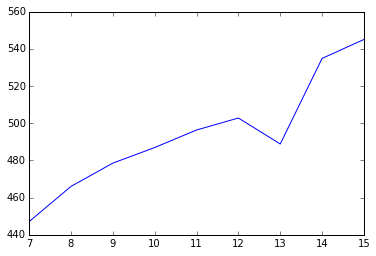

In [14]:
%matplotlib inline

from __future__ import division
from collections import defaultdict

import csv
import matplotlib.pyplot as plt
import numpy as np

vat = []

with open('data/vat.csv', 'rb') as f:
    reader = csv.reader(f)
    reader.next()  # discard headers
    for [year, month, vat_value] in reader:
        if month == "01janvier":
            vat += [(int(year) - 2000, float(vat_value) / 1e6)]
vat.sort()
vat_X = np.c_[np.ones(len(vat)), np.array([x for (x, y) in vat])]
vat_y = np.array([y for (x, y) in vat])
if True:
    print 'Sample of the input:', vat_X[:10]
    print 'Sample of the output:', vat_y[:10]

plt.plot(vat_X[:,1], vat_y)
plt.show()

Pour prédire automatiquement la valeur perçue en 2016, il faut réussir à comprendre l'évolution jointe de la TVA perçue et du temps. C'est ce que l'on va faire maintenant.

Pour commencer, on va se limiter à une hypothèse forte : on peut trouver une fonction affine qui modélise correctement la relation entre les entrées et les sorties (ici, les années et la TVA perçue). Pour rappel, une fonction affine est de la forme $h_\theta(x) = \theta_0 + \theta_1 \times x $. 

Géométriquement, on pourra représenter cette fonction par une droite qui ne passera par $(0, 0)$ que si $\theta_0$ est nul.

Par exemple, ici, on aimerait trouver l'hypothèse suivante :

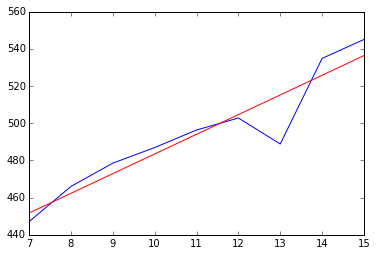

θ₀ = 377.703752912; θ₁ = 10.5761782005


In [15]:
from sklearn import linear_model

clf = linear_model.LinearRegression(fit_intercept=False)
clf.fit(vat_X, vat_y)
plt.plot(vat_X[:, 1], vat_y, 'b')
plt.plot(vat_X[:, 1], clf.predict(vat_X), 'r')
plt.show()

print 'θ₀ = %s; θ₁ = %s' % (clf.coef_[0], clf.coef_[1])

Cette droite nous permet facilement de prédire de nouvelles valeurs grâce à l'équation suivante :

$$
\begin{align}
  h_\theta   & = \theta_0       + \theta_1      \times \text{X} \\
  \text{TVA} & = 377.703752912 + 10.5761782005 \times \text{Année}
\end{align}
$$

Par exemple, on peut prédire pour l'année 2016 une perception de $377.703752912 + 10.5761782005 \times 2016 = 546,92260412$M€.

Tout ça est prometteur, mais ici nous avons utilisé [`scikit-learn`](http://scikit-learn.org/stable/) pour calculer les paramètres de l'hypothèse qui représente au mieux les données. Nous allons maintenant voir comment le faire nous même.

### Estimation des paramètres

Pour estimer $\theta$ ($\theta_0$ et $\theta_1$), nous avons besoin de 2 éléments :

- une fonction de coût, qui nous dira pour des paramètres donnés $\theta$ si l'on se débrouille bien ou non
- une méthode d'estimation des meilleurs paramètres étant donnée cette fonction de coût

#### Fonction de coût

La fonction de coût la plus utilisée est la moyenne des différences entre les points réels et ceux obtenus par l'hypothèse avec les paramètres courants, le tout au carré. Pour illustrer :

![Illustration of linear least squares by Oleg Alexandrov](files/img/least-squares.png)

Dans cette exemple, si notre hypothèse est la droite bleue, alors la coût de cette hypothèse est la somme des carrés des segments verts.

En notant $J$ la fonction de coût, $m$ le nombre d'exemples d'apprentissage, $X^{(i)}$ le $i^e$ input du dataset et $y^{(i)}$ le $i^e$ output du dataset, on peut écrire :

$$
J(\theta) = \frac{1}{2m}\sum^m_{i=1}\left(h_\theta(X^{(i)}) - y^{(i)}\right)^2
$$

Note  : on a divisé par 2 pour simplifier les maths qui suivent.

#### Optimisation des paramètres

Optimiser les paramètres revient à minimiser la fonction de coût :

$$\min_{\theta} \frac{1}{2m}\sum^m_{i=1}\left(h_\theta(X^{(i)}) - y^{(i)}\right)^2$$

Pour ce faire, il existe une formule directe que nous n'utiliserons pas ce soir pour deux raisons : elle n'est pas applicable aux très grands datasets et la méthode que l'on va utiliser pourra être réutilisée pour la régression logistique.

Nous allons utiliser la descente de gradient. Cette méthode est itérative et fait des pas successifs en suivant la dérivée (pour maximiser) ou son opposé (pour minimiser). Dans le cas de la régression linéaire, elle converge vers l'optimum global (la meilleure solution).

![An illustration of the gradient descent method by Oleg Alexandrov](files/img/gradient-descent.png)

En pseudo-code, l'algorithme est:

$$
\begin{align}
& \text{tant que ça n'a pas convergé :} \\
& \quad \theta \leftarrow \theta - \alpha \frac{\delta}{\delta\theta} J(\theta)
\end{align}
$$

où $\alpha$ est le pas d'apprentissage et où $\frac{\delta}{\delta\theta} J(\theta)$ est la dérivée de la fonction de coût par rapport à $\theta$.

Pour pouvoir implémenter cet algorithme d'optimisation, il nous faut donc calculer la dérivée de la fonction de coût par rapport à $\theta$. Prenez le résultat tel quel si les maths vous embêtent :

$$
\begin{align}
\frac{\delta}{\delta\theta} J(\theta) & = \frac{\delta}{\delta\theta} \frac{1}{2m}\sum^m_{i=1}\left(h_\theta(X^{(i)}) - y^{(i)}\right)^2 \\
& = \frac{1}{m}\sum^m_{i=1}\left(X^T(X\theta^T - y)\right) \\
\end{align}
$$

Si au contraire vous souhaitez approfondir la chose, voir http://math.stackexchange.com/questions/70728/partial-derivative-in-gradient-descent-for-two-variables/189792#189792.

On peut maintenant coder ça en python !

In [1]:
def cost_function(X, y, theta):
    # TODO
    pass

def gradient_function(X, y, theta):
    # TODO
    pass

def gradient_approx_function(X, y, theta, epsilon=0.000001):
    grads = []
    for i in range(theta.size):
        below = theta.copy()
        below[i] -= epsilon
        above = theta.copy()
        above[i] += epsilon
        grads += [(cost_function(X, y, above) - cost_function(X, y, below))
                  / (2 * epsilon)]
    return np.array(grads)

def predict(X, theta):
    # TODO
    pass

def gradient_descent(X,
                     y,
                     alpha,
                     max_iter=1000, gradient_check=True):
    # TODO
    pass
#theta, costs = gradient_descent(vat_X, vat_y, 0.006, 10000)
#plt.plot(vat_X[:, 1], vat_y, 'b')
#plt.plot(vat_X[:, 1], predict(vat_X, theta), 'r')
#plt.show()
#print 'θ₀ = %s; θ₁ = %s' % (theta[0], theta[1])
#plt.plot(range(len(costs)), costs)
#plt.show()


## Régression logistique

Cette fois ci, on cherche à prédire une variable qui prend des valeurs dans certaines classes et non pas une valeur précise. Malgré le nom de cette technique (régression logistique), on ne fait plus de la régression mais de la classification.

Pour travailler cette nouvelle technique, on utilisera le [dataset](http://data.nantes.fr/donnees/detail/adresses-postales-de-nantes-metropole/) de Nantes Open Data contenant toutes les adresses postales de Nantes Métropole.. Notre but ? À partir des coordonnées GPS d'une rue, on cherche à savoir si elle se trouve ou non dans la zone du code postal 44000. Regardons en python à quoi ressemble le dataset :

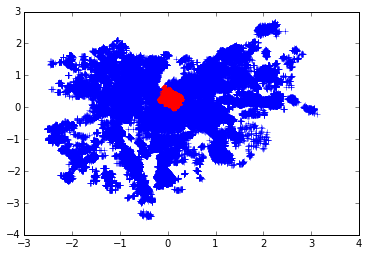

In [18]:
addresses_X = []
addresses_y = []

with open('data/addresses.csv', 'rb') as f:
    reader = csv.reader(f)
    reader.next()  # discard headers
    for [zipcode, longitude, latitude] in reader:
        addresses_X += [(float(latitude), float(longitude))]
        addresses_y += [zipcode if zipcode == '44000' else 'Other']

addresses_X, addresses_y = np.array(addresses_X), np.array(addresses_y)
# normalization
addresses_X -= addresses_X.mean(axis=0)
addresses_X /= addresses_X.std(axis=0)
addresses_X = np.c_[np.ones(addresses_y.size), addresses_X]

if False:
    print 'Sample of the input:', addresses_X[:10]
    print 'Sample of the output:', addresses_y[:10]

idx_44000 = addresses_y == '44000'
idx_not_44000 = np.logical_not(idx_44000)

plt.plot(addresses_X[idx_44000, 1], addresses_X[idx_44000, 2], 'r+')
plt.plot(addresses_X[idx_not_44000, 1], addresses_X[idx_not_44000, 2], 'b+')
plt.show()

Notre but est donc d'apprendre la zone rouge de manière automatique afin de pouvoir déclarer les GPS qu'elle contient comme étant 44000.

Cette fois-ci, au lieu d'apprendre une fonction de type

$$h_\theta(\text{long}, \text{lat}) = \theta_0 + \theta_1 \times \text{long} + \theta_2 \times \text{lat}$$

comme on l'aurait fait avec une régression linéaire, on va apprendre une fonction de type

$$h_\theta(\text{long}, \text{lat}) = \sigma\left(\theta_0 + \theta_1 \times \text{long} + \theta_2 \times \text{lat}\right)$$

où
$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

Cette fonction $\sigma$ ressemble à

![The logistic sigmoid function by Qef](files/img/sigmoid-function.svg).

Intuitivement, la différence par rapport à la régression linéaire est que la fonction $\sigma$ va nous permettre d'attribuer une classe à un objet d'entrée en fonction de sa distance avec la frontière linéaire entre les classes.

Comme tout à l'heure, commençons par le faire avec scikit-learn :

h = σ(-8.0990450701 + -27.9349597427 * lat + -49.6559424896 * long + 145.176144407 * lat² + 25.6461740769 * lat * long + 93.2806543721 * long²)


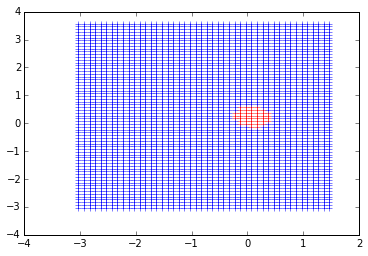

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

# we'll needs polynomial features, sklearn has a handy tool for that
# 1, a, b, a^2, ab, b^2
poly = PolynomialFeatures(degree=2)
addresses_X_poly = poly.fit_transform(addresses_X[:, 1:])

# poly already adds the bias, so it's important not to let fit_intercept
# to True
logreg = LogisticRegression(C=1e5, fit_intercept=False)
logreg.fit(addresses_X_poly, addresses_y)
print "h = σ(%s + %s * lat + %s * long + " \
      "%s * lat² + %s * lat * long + %s * long²)" % tuple(logreg.coef_[0])

# let's predict & plot everything on a square to see what's the
# classification frontier
x_min, x_max = addresses_X[:, 1].min() - .5, addresses_X[:, 0].max() + .5
y_min, y_max = addresses_X[:, 1].min() - .5, addresses_X[:, 1].max() + .5
step = 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                     np.arange(y_min, y_max, step))
coords = np.c_[xx.ravel(), yy.ravel()]
Z = logreg.predict(poly.fit_transform(coords))

idx_Z_44000 = Z == '44000'
idx_Z_not_44000 = np.logical_not(idx_Z_44000)

plt.plot(coords[idx_Z_44000, 0], coords[idx_Z_44000, 1], 'r+')
plt.plot(coords[idx_Z_not_44000, 0], coords[idx_Z_not_44000, 1], 'b+')
plt.show()

Comme tout à l'heure, nous aurons besoin d'une fonction de coût et d'une méthode d'optimisation. La méthode ne change pas, seule la fonction de coût et sa dérivée sont à re-étudier :

#### Fonction de coût

De manière générale, on peut écrire une fonction de coût comme :

$$
J(\theta) = \frac{1}{m}\sum^m_{i=1}\text{Cost}\left(h_\theta(x^{(i)}), y^{(i)}\right)
$$

avec $\text{Cost}$ à définir. Pour la régression logistique, on utilise
$$
\begin{cases} 
 -\log(h_\theta(x)) & \text{si } y = 1 \\
 -\log(1 - h_\theta(x)) & \text{si } y = 0 \\
\end{cases}
$$

On peut réécrire cette fonction comme suit :

$$
\text{Cost}\left(h_\theta(x^{(i)}), y^{(i)}\right) = -y\log(h_\theta(x)) -(1 - y)\log(1 - h_\theta(x))
$$

#### Dérivée de la fonction de coût

Une dérivation complète est disponible sur [Coursera](https://share.coursera.org/wiki/index.php/ML:Logistic_Regression) (gratuit, nécessite une inscription). Nous donnerons ici seulement la forme finale, qui ne diffère de celle de la régression linéaire que pour la nature de l'hypothèse $h$ (avec sa fonction $\sigma$ additionnelle) :

$$
\frac{\delta}{\delta\theta}J(h\theta) = \frac{\delta}{\delta\theta} \frac{1}{m}\sum^m_{i=1}\left(h_\theta(X^{(i)}) - y^{(i)}\right)X^{(i)}
$$

L'implémentation est la même que celle que l'on a faite pour la régression linéaire, à la fonction de coût et à cette dérivée près. Essayez de la compléter pour solidifier vos bases !

## Pour aller plus loin

- [L'excellent Coursera d'Andrew Ng sur le Machine Learning](https://www.coursera.org/learn/machine-learning/home/welcome) : Introduction avec travaux pratiques sur de nombreuses tâches du Machine Learning. Très adapté pour obtenir une première vue d'ensemble pertinente.

- [La ML Week](http://www.ml-week.com/fr/) : Formation intensive sur 4 jours pour comprendre les fondations du Machine Learning, bientôt (du 2 au 5 novembre) et sur Nantes !

- [Le sous-reddit Machine Learning](https://www.reddit.com/r/MachineLearning) : Plus pour l'actualité et les nouveaux développements que pour les bases mais très utile à mon goût.